# Get started

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/get_started.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of time series forecasting pipeline
using ETNA library.

**Table of Contents**

* [Creating TSDataset](#chapter1)
* [Plotting](#chapter2)
* [Forecast single time series](#chapter3)
    * [Simple forecast](#section_3_1)
    * [Prophet](#section_3_2)
    * [Catboost](#section_3_3)
* [Forecast multiple time series](#chapter4)
* [Pipeline](#chapter5)

In [1]:
import warnings

warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")

## 1. Creating TSDataset <a class="anchor" id="chapter1"></a>

Let's load and look at the dataset

In [2]:
import pandas as pd

In [3]:
original_df = pd.read_csv("data/monthly-australian-wine-sales.csv")
original_df.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


etna_ts is strict about data format:
* column we want to predict should be called `target`
* column with datatime data should be called `timestamp`
* because etna is always ready to work with multiple time series, column `segment` is also compulsory

Our library works with the special data structure TSDataset. So, before starting anything, we need to convert the classical DataFrame to TSDataset.

Let's rename first

In [4]:
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


Time to convert to TSDataset!

To do this, we initially need to convert the classical DataFrame to the special format.

In [5]:
from etna.datasets.tsdataset import TSDataset

In [6]:
df = TSDataset.to_dataset(original_df)
df.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


Now we can construct the TSDataset.

Additionally to passing dataframe we should specify frequency of our data.
In this case it is monthly data.

In [7]:
ts = TSDataset(df, freq="1M")

/Users/a.p.chikov/PycharmProjects/etna_dev/etna-ts/etna/datasets/tsdataset.py:144: UserWarning: You probably set wrong freq. Discovered freq in you data is MS, you set 1M
  warnings.warn(


Oups. Let's fix that

In [8]:
ts = TSDataset(df, freq="MS")

We can look at the basic information about the dataset

In [9]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          1980-01-01    1994-08-01     176            0


Or in DataFrame format

In [10]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1980-01-01,1994-08-01,176,0,1,0,0,0,MS


## 2. Plotting <a class="anchor" id="chapter2"></a>

Let's take a look at the time series in the dataset

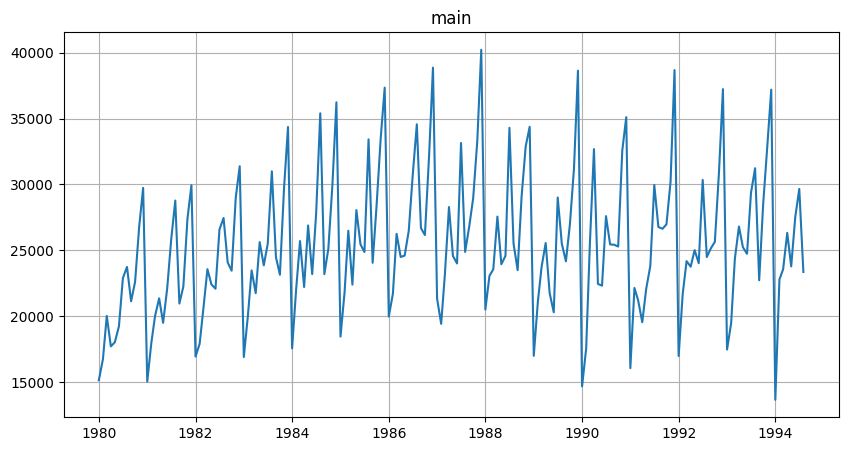

In [11]:
ts.plot()

## 3. Forecasting single time series <a class="anchor" id="chapter3"></a>

Our library contains a wide range of different models for time series forecasting. Let's look at some of them.

### 3.1 Simple forecast<a class="anchor" id="section_3_1"></a>
Let's predict the monthly values in 1994 in our dataset using the ```NaiveModel```

In [12]:
train_ts, test_ts = ts.train_test_split(
    train_start="1980-01-01",
    train_end="1993-12-01",
    test_start="1994-01-01",
    test_end="1994-08-01",
)

In [13]:
HORIZON = 8
from etna.models import NaiveModel

# Fit the model
model = NaiveModel(lag=12)
model.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)

Here we pass `prediction_size` parameter during `forecast` because in `forecast_ts` few first points are dedicated to be a context for `NaiveModel`.

Now let's look at a metric and plot the prediction.
All the methods already built-in in etna.

In [14]:
from etna.metrics import SMAPE

In [15]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 11.492045838249387}

In [16]:
from etna.analysis import plot_forecast

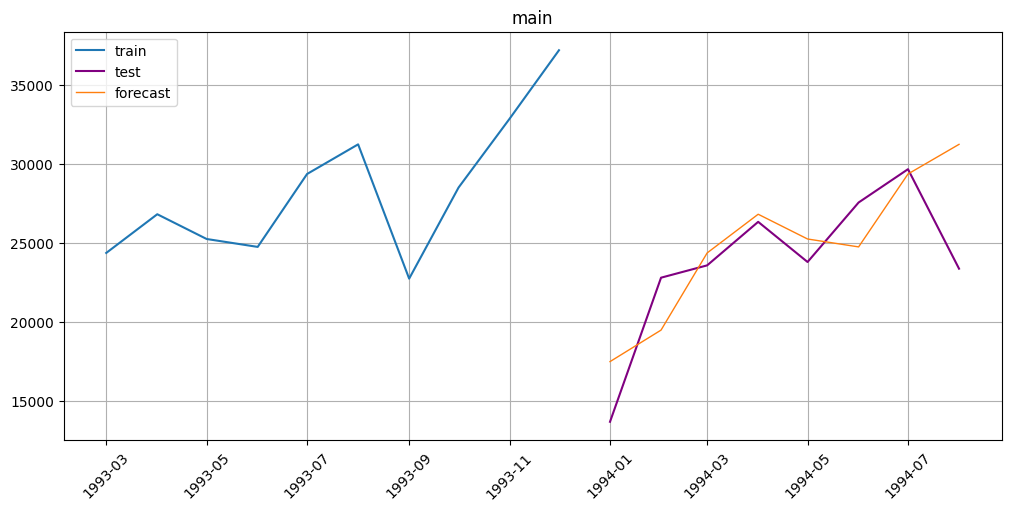

In [17]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 3.2 Prophet<a class="anchor" id="section_3_2"></a>

Now try to improve the forecast and predict the values with Prophet.

In [18]:
from etna.models import ProphetModel

model = ProphetModel()
model.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

08:56:22 - cmdstanpy - INFO - Chain [1] start processing
08:56:22 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.510260655718435}

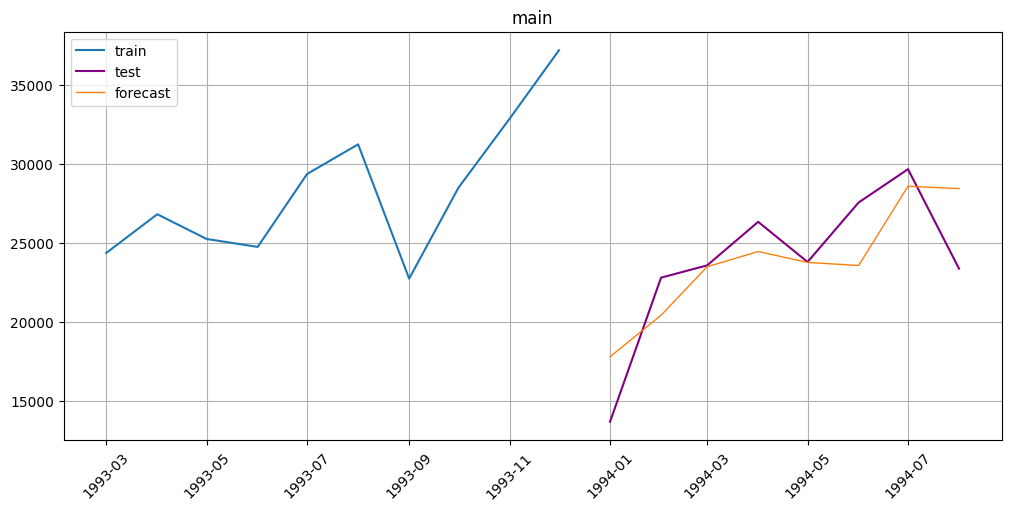

In [20]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 3.2 Catboost<a class="anchor" id="section_3_3"></a>
And finally let's try the Catboost model.

Also etna has wide range of transforms you may apply to your data.

Transforms are not stored in the dataset, so you should pass them explicitly to `transform`, `inverse_transform` and `make_future` methods.

Here how it is done:

In [21]:
from etna.transforms import LagTransform, LogTransform

lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))
log = LogTransform(in_column="target")
transforms = [log, lags]
train_ts.fit_transform(transforms)

In [22]:
from etna.models import CatBoostMultiSegmentModel

model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)

In [23]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.657026308972483}

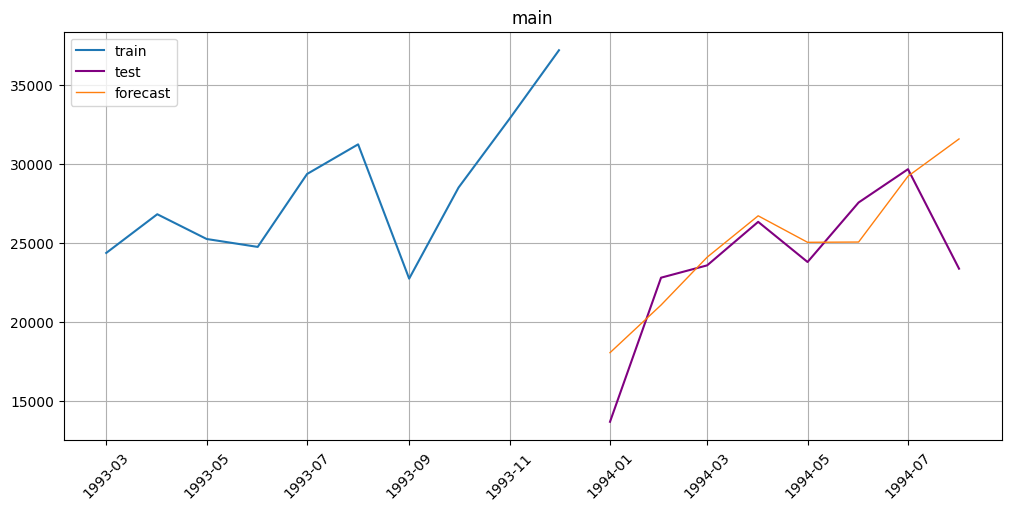

In [24]:
from etna.analysis import plot_forecast

train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

## 4. Forecasting multiple time series <a class="anchor" id="chapter4"></a>

In this section you may see example of how easily etna works
with multiple time series and get acquainted with other transforms etna contains.

In [25]:
original_df = pd.read_csv("data/example_dataset.csv")
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


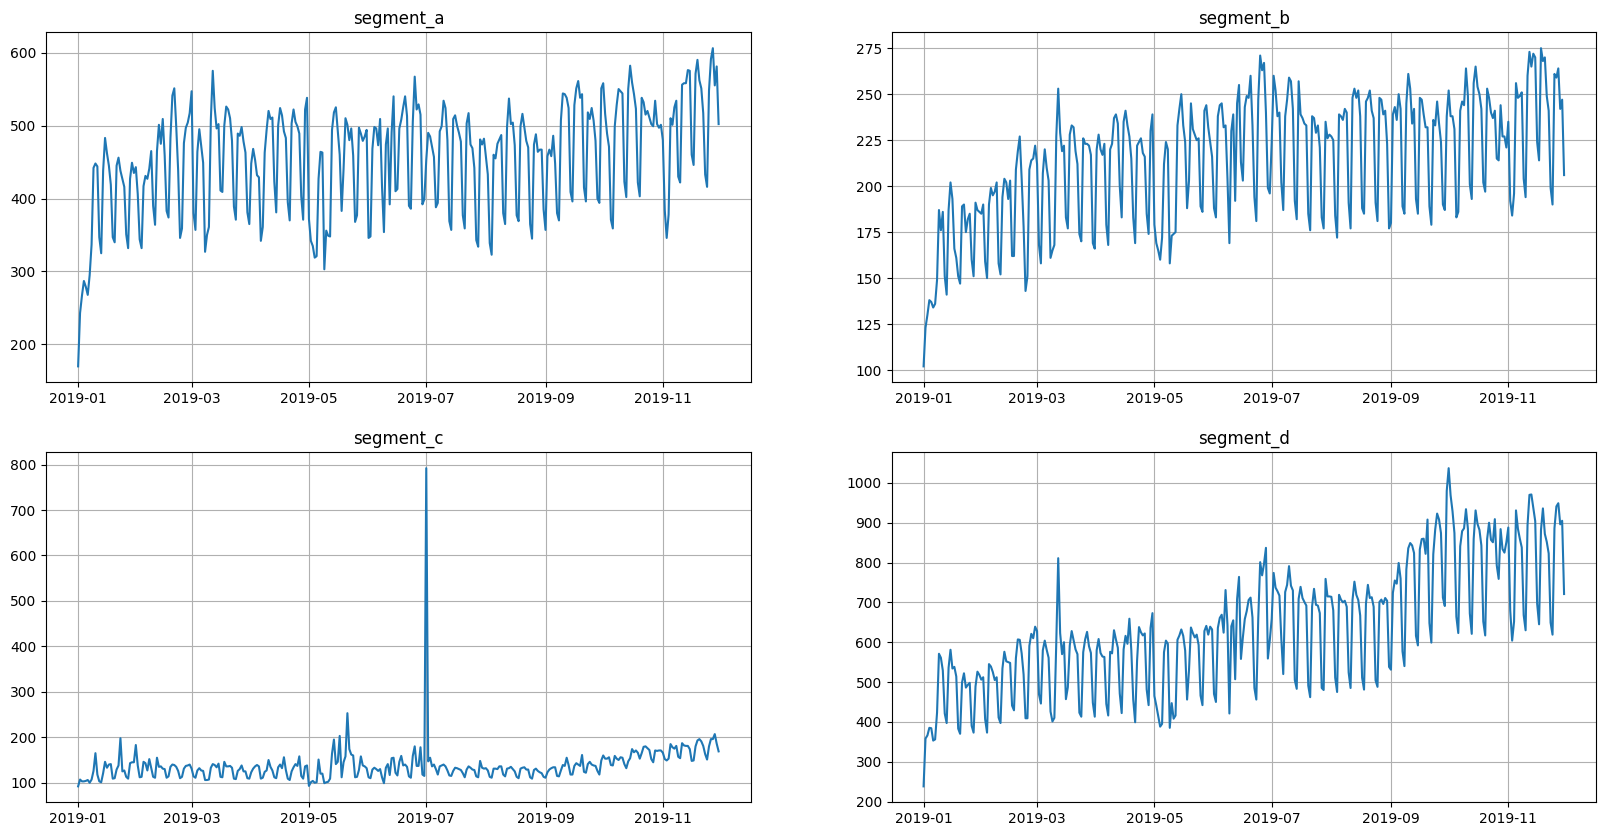

In [26]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")
ts.plot()

In [27]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-01-01    2019-11-30     334            0
segment_b      2019-01-01    2019-11-30     334            0
segment_c      2019-01-01    2019-11-30     334            0
segment_d      2019-01-01    2019-11-30     334            0


In [28]:
import warnings

from etna.transforms import (
    MeanTransform,
    LagTransform,
    LogTransform,
    SegmentEncoderTransform,
    DateFlagsTransform,
    LinearTrendTransform,
)

warnings.filterwarnings("ignore")

log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(30, 96, 1)))
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6],
)
mean30 = MeanTransform(in_column="target", window=30)
transforms = [log, trend, lags, d_flags, seg, mean30]

In [29]:
HORIZON = 30
train_ts, test_ts = ts.train_test_split(
    train_start="2019-01-01",
    train_end="2019-10-31",
    test_start="2019-11-01",
    test_end="2019-11-30",
)
train_ts.fit_transform(transforms)

In [30]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-11-01    2019-11-30      30            0
segment_b      2019-11-01    2019-11-30      30            0
segment_c      2019-11-01    2019-11-30      30            0
segment_d      2019-11-01    2019-11-30      30            0


In [31]:
from etna.models.catboost import CatBoostMultiSegmentModel

model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)

In [32]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_b': 4.210896545479218,
 'segment_a': 6.059390208724575,
 'segment_d': 4.98784059255331,
 'segment_c': 11.729007773459314}

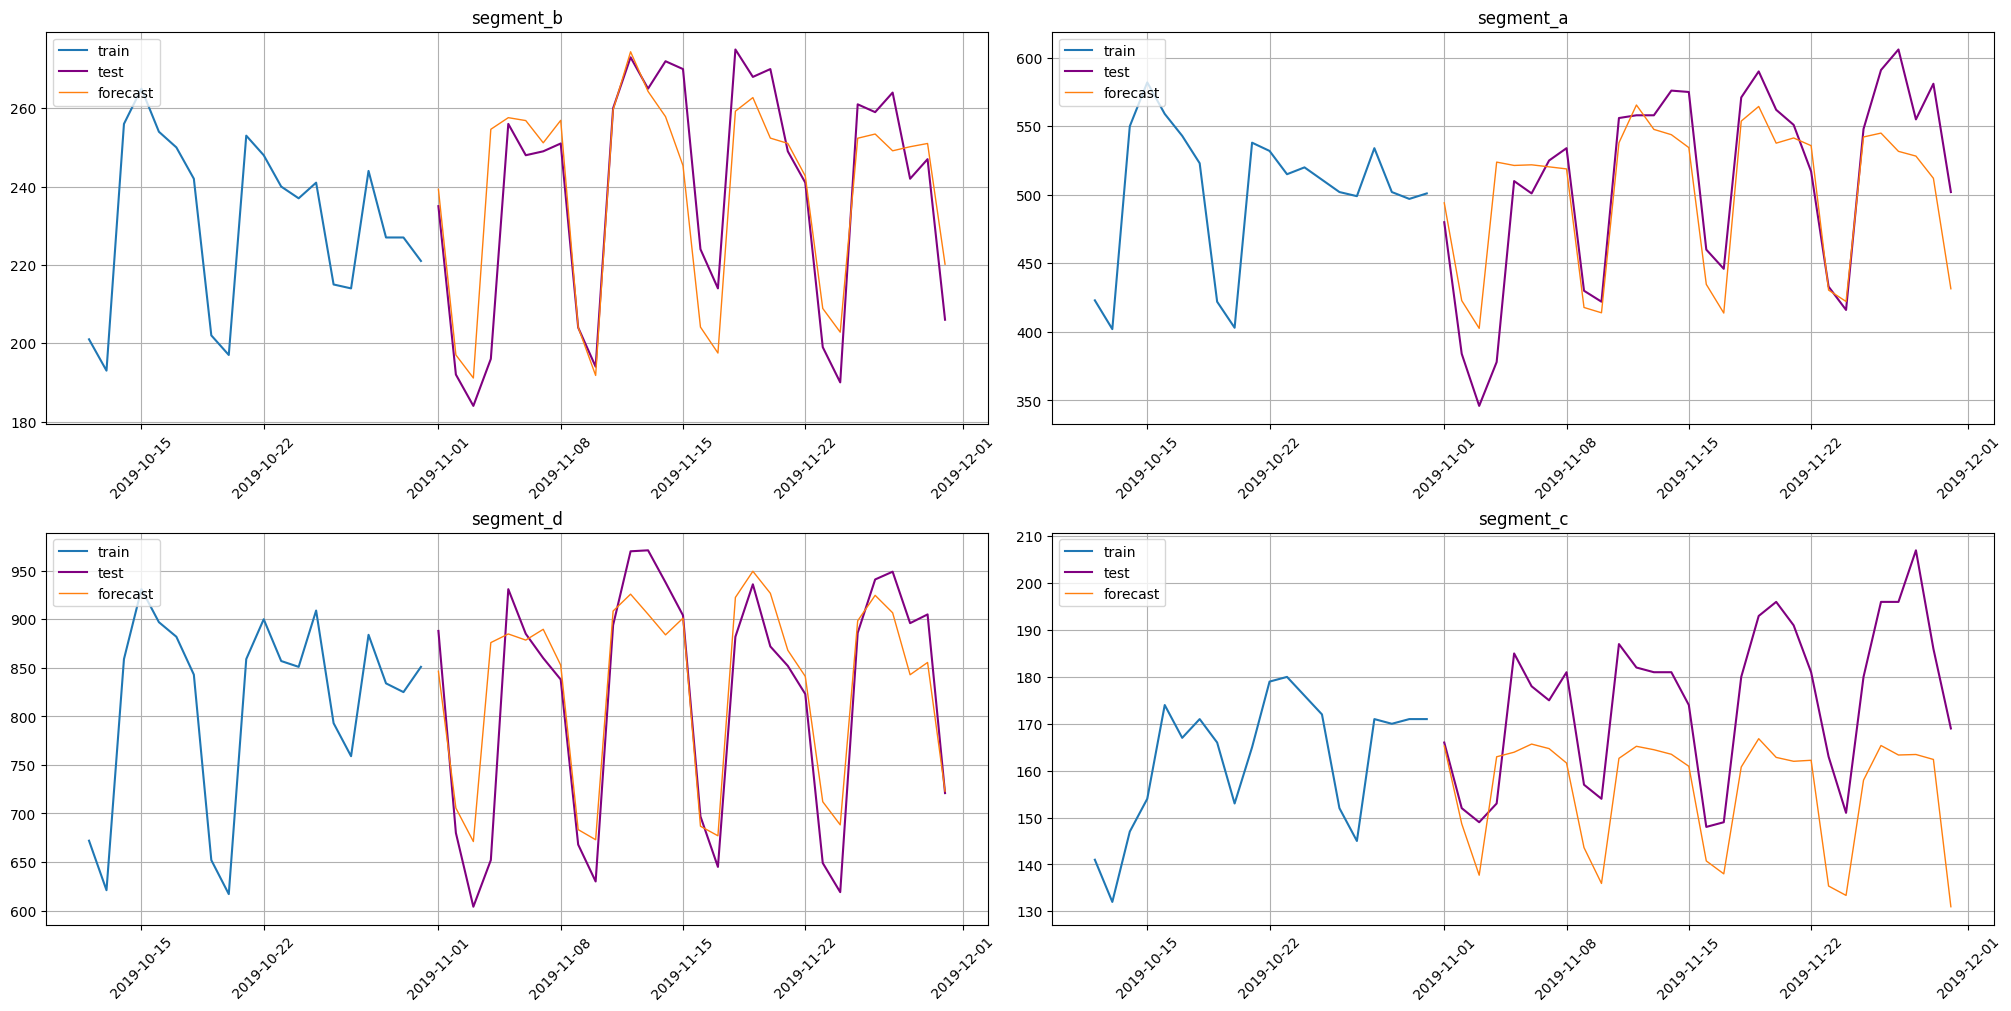

In [33]:
train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

## 5. Pipeline <a class="anchor" id="chapter5"></a>

Let's wrap everything into pipeline to create the end-to-end model from previous section.

In [34]:
from etna.pipeline import Pipeline

In [35]:
train_ts, test_ts = ts.train_test_split(
    train_start="2019-01-01",
    train_end="2019-10-31",
    test_start="2019-11-01",
    test_end="2019-11-30",
)

We put: **model**, **transforms** and **horizon** in a single object, which has the similar interface with the model(fit/forecast)

In [36]:
model = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=transforms,
    horizon=HORIZON,
)
model.fit(train_ts)
forecast_ts = model.forecast()

As in the previous section, let's calculate the metrics and plot the forecast

In [37]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_b': 4.210896545479218,
 'segment_a': 6.059390208724575,
 'segment_d': 4.98784059255331,
 'segment_c': 11.729007773459314}

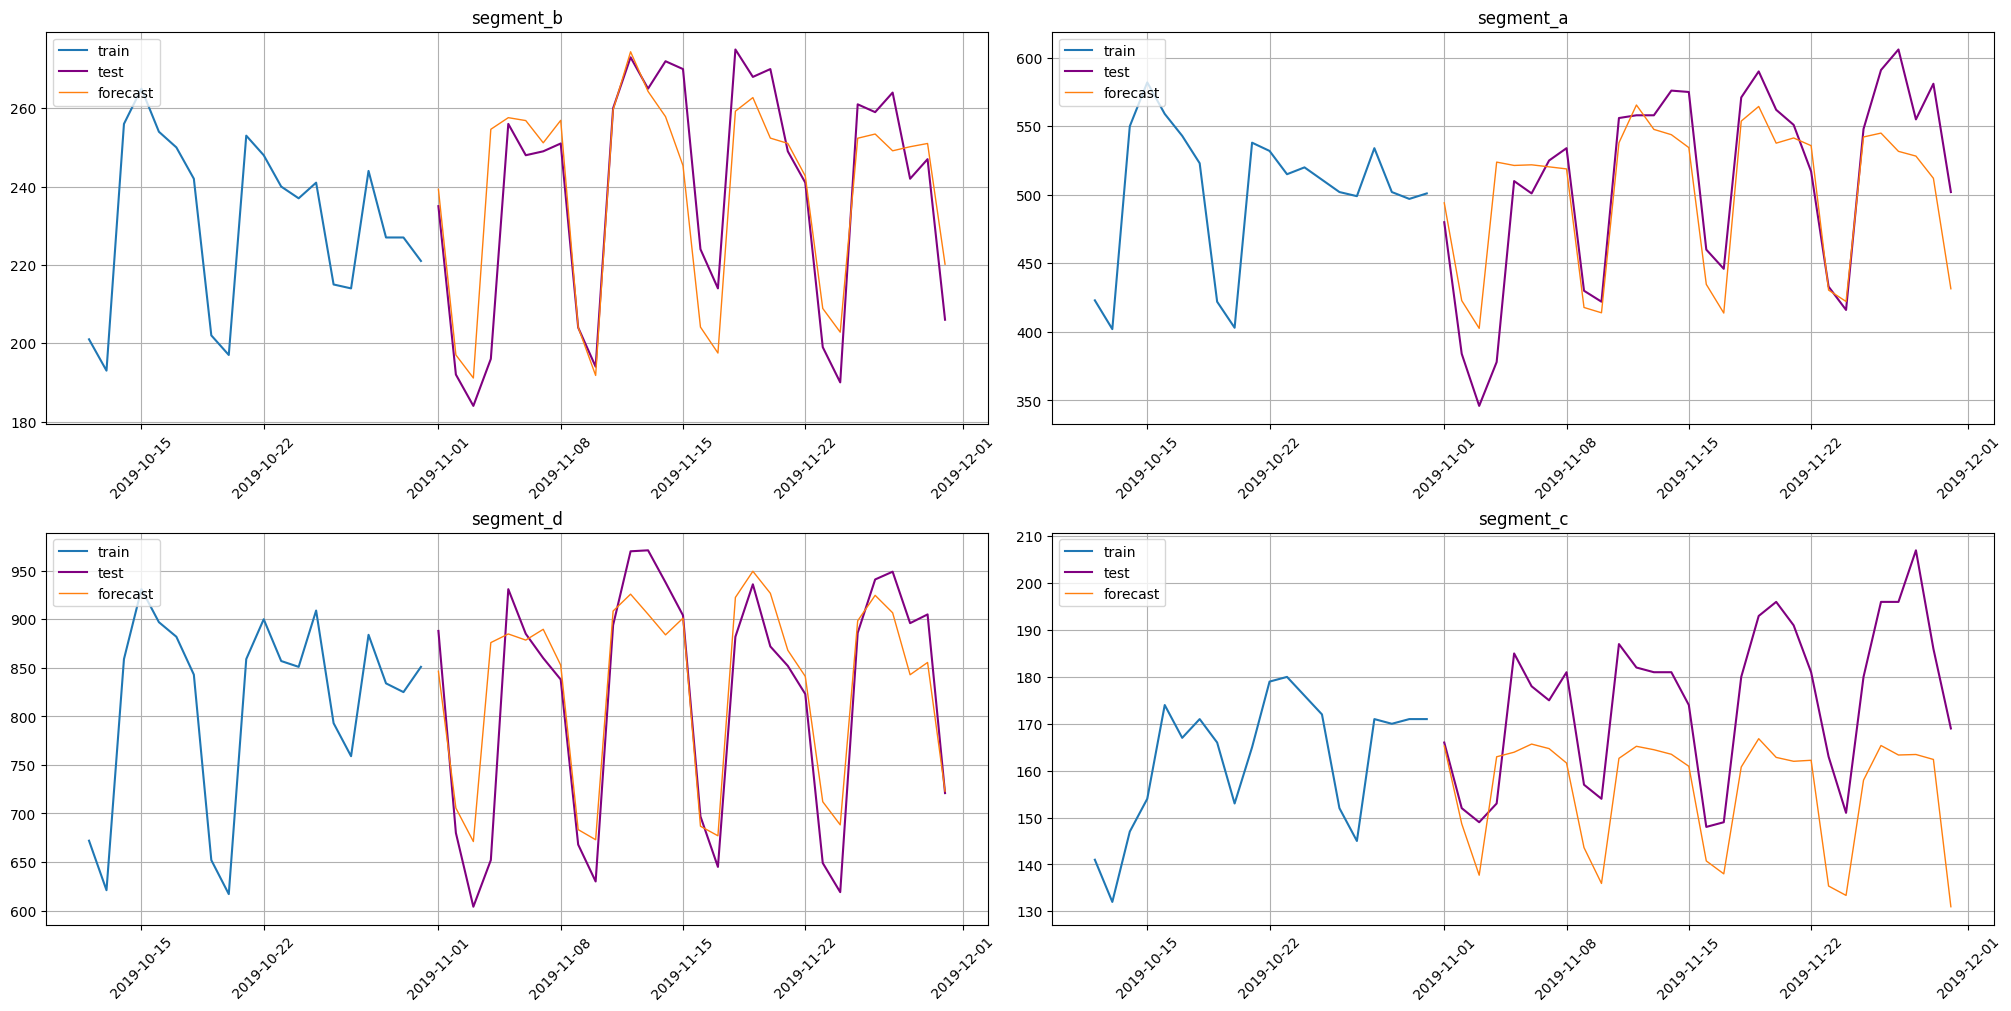

In [38]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)